# Imports

In [76]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from wing import WingsOfEvidence
import wing
print(wing.__version__)

0.0.10


# Строим тестовый набор данных

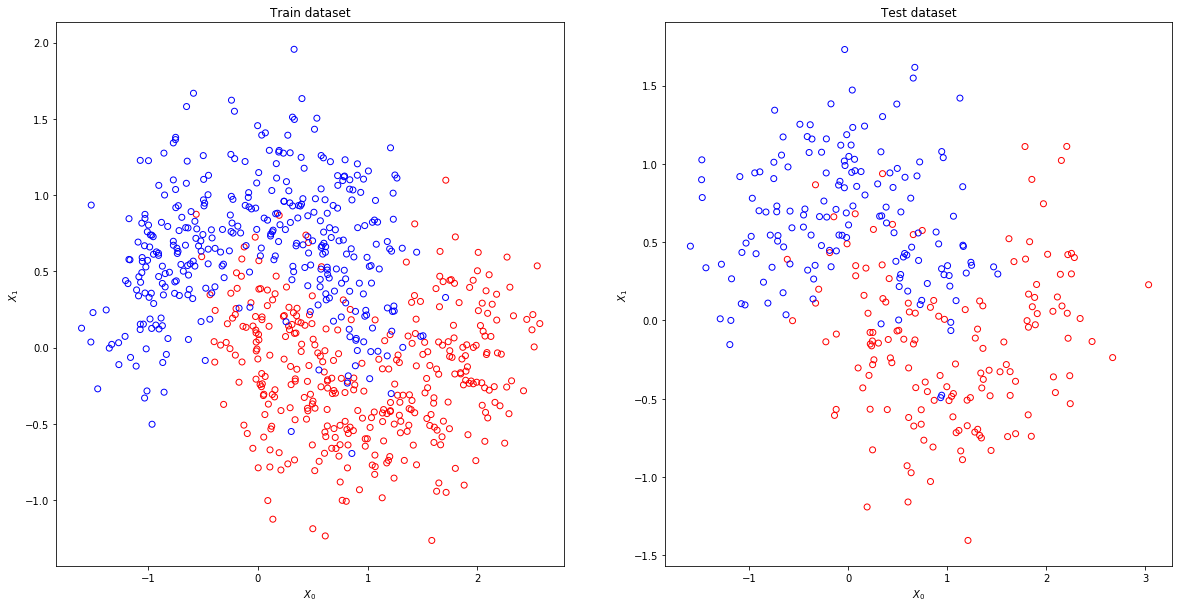

In [99]:
# create data
N_SAMPLES = 1000
X,y = make_moons(n_samples=N_SAMPLES,noise=0.3)

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.3)

f, (ax1, ax2) = plt.subplots(ncols=2,figsize=(20,10))
# plot train
ax1.scatter(X_train[y_train == 1,0],X_train[y_train == 1,1],facecolors='none', edgecolors='r')
ax1.scatter(X_train[y_train == 0,0],X_train[y_train == 0,1],facecolors='none', edgecolors='b')
ax1.set_title('Train dataset')
ax1.set_xlabel('$X_0$')
ax1.set_ylabel('$X_1$')

# plot test

ax2.scatter(X_test[y_test == 1,0],X_test[y_test == 1,1],facecolors='none', edgecolors='r')
ax2.scatter(X_test[y_test == 0,0],X_test[y_test == 0,1],facecolors='none', edgecolors='b')
ax2.set_title('Test dataset')
ax2.set_xlabel('$X_0$')
ax2.set_ylabel('$X_1$')
print()

# $WoE$ transform

In [104]:
%%time
wings = WingsOfEvidence(columns_to_apply='all',n_initial=20,n_target=5,only_values=True)
X_train_df = pd.DataFrame(X_train,columns=['X0','X1'])
X_test_df = pd.DataFrame(X_test,columns=['X0','X1'])
wings.fit(X_train_df,y_train)
X_train_woe = wings.transform(X_train_df)
X_test_woe = wings.transform(X_test_df)
X_train_transformed = X_train_woe.copy()
X_train_transformed['X0_base'] = X_train[:,0]
X_train_transformed['X1_base'] = X_train[:,1]

CPU times: user 2min, sys: 335 ms, total: 2min
Wall time: 2min


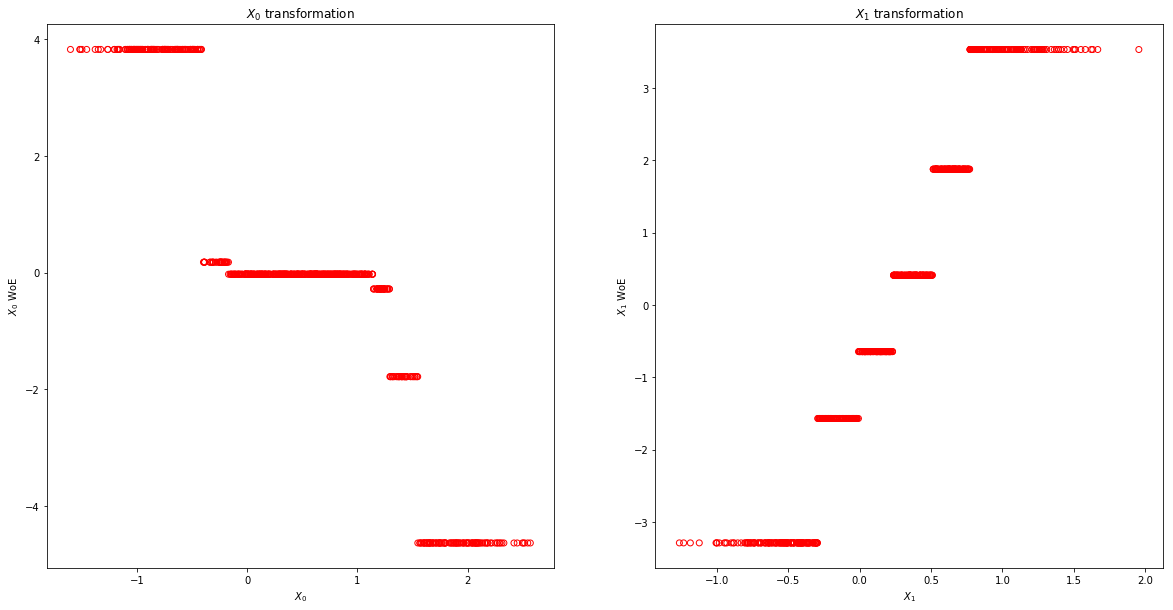

In [105]:
f, (ax1, ax2) = plt.subplots(ncols=2,figsize=(20,10))
# plot train
ax1.scatter(X_train_transformed['X0_base'],X_train_transformed['WOE_X0'],facecolors='none', edgecolors='r')
ax1.set_title('$X_0$ transformation')
ax1.set_xlabel('$X_0$')
ax1.set_ylabel('$X_0$ WoE')
# plot test

ax2.scatter(X_train_transformed['X1_base'],X_train_transformed['WOE_X1'],facecolors='none', edgecolors='r')
ax2.set_title('$X_1$ transformation')
ax2.set_xlabel('$X_1$')
ax2.set_ylabel('$X_1$ WoE')
print()

In [106]:
woe_lr_m = LogisticRegressionCV(n_jobs=-1)
def_lr_m = LogisticRegressionCV(n_jobs=-1)

woe_lr_m.fit(X_train_woe,y_train)
def_lr_m.fit(X_train,y_train)

print('Selected C for WoE LogReg: %0.4f'%woe_lr_m.C_)
print('Selected C for Def LogReg: %0.4f'%def_lr_m.C_)

Selected C for WoE LogReg: 0.0008
Selected C for Def LogReg: 0.3594


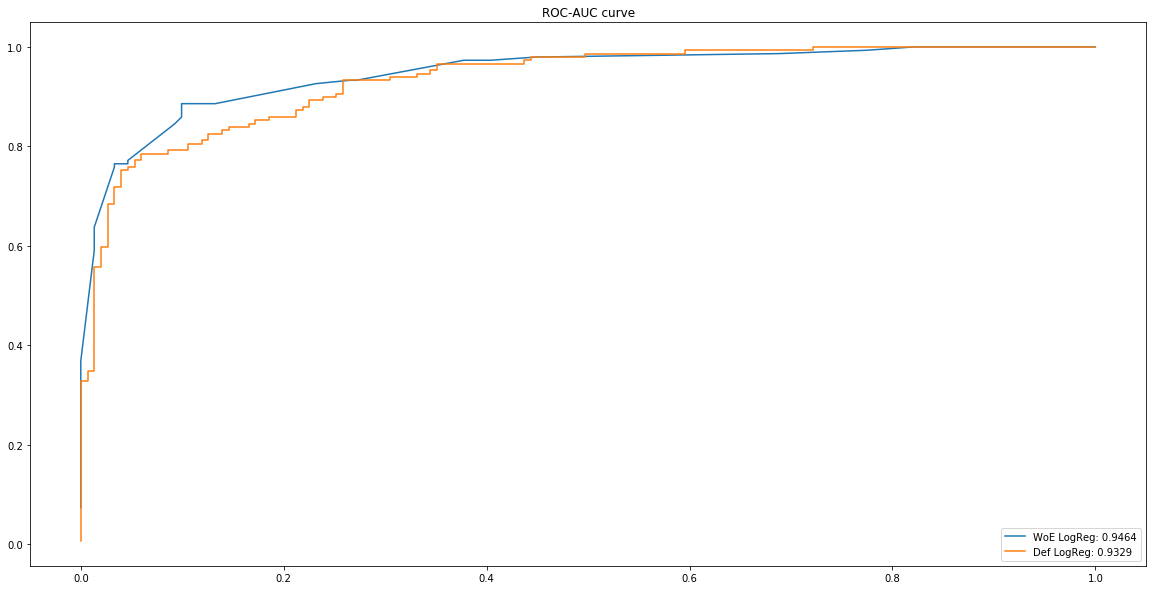

In [107]:
woe_test_proba = woe_lr_m.predict_proba(X_test_woe)[:,1]
woe_roc_v = roc_auc_score(y_test,woe_test_proba)
woe_tpr,woe_fpr,_ = roc_curve(y_test,woe_test_proba)

def_test_proba = def_lr_m.predict_proba(X_test)[:,1]
def_roc_v = roc_auc_score(y_test,def_test_proba)
def_tpr,def_fpr,_ = roc_curve(y_test,def_test_proba)


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)


ax.plot(woe_tpr,woe_fpr,label='WoE LogReg: %0.4f'%woe_roc_v)
ax.plot(def_tpr,def_fpr,label='Def LogReg: %0.4f'%def_roc_v)
ax.set_title('ROC-AUC curve')
ax.legend(loc='lower right')